<center> Imports <center>

<center> Null Hypothesis: The weather does not affect the amount of checkins <center> <br/>
<center> Alternate Hypothesis: The weather does affect the amount of checkins <center>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
from scipy import stats

 <center> Import check_in data from Yelp dataset <center>

In [2]:
file = '/Users/Lisa/Downloads/yelp_dataset/yelp_academic_dataset_checkin.json'

In [3]:
checkins = pd.read_json(file, lines=True)

In [4]:
checkins

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."
...,...,...
175182,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
175183,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
175184,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
175185,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."


 <center> Since the date column is a long string I'll need to change it to a list in order to leverage date/time for future graphing <center>

In [5]:
checkins['date'] = checkins['date'].apply(lambda x: x.split(","))

 <center> Leverage dataframe.explode('column_name') to break the list of check-in's down <center>

In [6]:
checkins_broken_down = checkins.explode('date')

 <center> From my EDA is seems like each business has a unique business_id which gives a breakdown of the dates people checked in to these businesses. I can use that to compare against the weather for those dates. <br/> Now Identify the locations with enough data points to scrap weather data for <center>

 <center> Import Business data from Yelp dataset <center>

In [7]:
file2 = '/Users/Lisa/Downloads/yelp_dataset/yelp_academic_dataset_business.json'

In [8]:
businesses = pd.read_json(file2, lines=True)

 <center> Clean up businesses dataframe and elimnate unnecessary columns since its not data I need to focus on <center>

In [9]:
businesses = businesses.drop(['hours', 'categories', 'attributes', 'longitude', 'latitude', 'stars', 'is_open', 'address', 'postal_code', 'review_count'], axis=1)

 <center> Idnetify a State with enough data points to work with (since there's a lot of entries) <center>

In [10]:
businesses.groupby('state').count()

,business_id,name,city
state,,,
AB,8682,8682,8682
AK,1,1,1
AL,3,3,3
AR,1,1,1
AZ,60803,60803,60803
BC,2,2,2
CA,23,23,23
CO,2,2,2
CT,2,2,2


<center>It seems like Arizona has the most amount of Yelp Activity <br/> Determine which city to focus on in AZ. <br/> Groupby and sort the counted data<center>

In [11]:
AZ = businesses.loc[businesses['state'] == 'AZ'].groupby('city').count()

<center>Take the grouped data and sort it<center>

In [12]:
AZ.sort_values('state', ascending=False)

,business_id,name,state
city,,,
Phoenix,20170,20170,20170
Scottsdale,9341,9341,9341
Mesa,6577,6577,6577
Tempe,4797,4797,4797
Chandler,4579,4579,4579
...,...,...,...
Mesa Az,1,1,1
Mesa Arizona,1,1,1
Mes,1,1,1


 <center> Through EDA, it seems like Phoenix has the greatest activity to measure against weather. Will focus on Yelp check-in's there<center>

 <center> Pull Pheonix, AZ from the businesses dataframe <center>

In [13]:
phx_az_biz = businesses.loc[(businesses['city']=='Phoenix') & (businesses['state']=='AZ')]

 <center> Merge Phoenix, AZ dataframe to checkins_broken_down <center>

In [14]:
phx_checkins = phx_az_biz.merge(checkins_broken_down, how='left', on='business_id')

 <center> get date/time to a workable data type (not a string!) <center>

<center> Example: data["Date"]= pd.to_datetime(data["Date"]) <center>

In [15]:
phx_checkins['date'] = pd.to_datetime(phx_checkins['date'])

In [16]:
phx_checkins['date2.0'] = phx_checkins['date'].dt.date

In [17]:
phx_checkins = phx_checkins.drop('date', axis=1)

 <center> Groupby and count dates <center>

 <center> Break up phx_checkins by years <center>

In [18]:
phx_checkins

,business_id,name,city,state,date2.0
0,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2010-08-17
1,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-07-08
2,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-08
3,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-09
4,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-21
...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07


In [19]:
# check to see how to access date/time
print(phx_checkins.iloc[0,4].month)
print(phx_checkins.iloc[0,4].day)
print(phx_checkins.iloc[0,4].year)

8
17
2010


In [20]:
# new columns for month, date, year
phx_checkins['Month'] = phx_checkins['date2.0'].apply(lambda x: x.month)

In [21]:
phx_checkins['Day'] = phx_checkins['date2.0'].apply(lambda x: x.day)

In [22]:
phx_checkins['Year'] = phx_checkins['date2.0'].apply(lambda x: x.year)

In [23]:
phx_checkins

,business_id,name,city,state,date2.0,Month,Day,Year
0,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2010-08-17,8.0,17.0,2010.0
1,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-07-08,7.0,8.0,2011.0
2,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-08,8.0,8.0,2011.0
3,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-09,8.0,9.0,2011.0
4,07cgbTbANYhVDfzTMOkB9w,Frontier Automotive,Phoenix,AZ,2011-08-21,8.0,21.0,2011.0
...,...,...,...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03,5.0,3.0,2019.0
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29,7.0,29.0,2019.0
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04,8.0,4.0,2019.0
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07,8.0,7.0,2019.0


 <center> Get a breakdown by year and the total amount of checkins. Next will be to separate them into years <center>

In [24]:
phx_checkins_years = phx_checkins.groupby('Year').count()
phx_checkins_years

,business_id,name,city,state,date2.0,Month,Day
Year,,,,,,,
2010.0,47024,47024,47024,47024,47024,47024,47024
2011.0,213274,213274,213274,213274,213274,213274,213274
2012.0,282346,282346,282346,282346,282346,282346,282346
2013.0,333793,333793,333793,333793,333793,333793,333793
2014.0,345027,345027,345027,345027,345027,345027,345027
2015.0,315325,315325,315325,315325,315325,315325,315325
2016.0,275605,275605,275605,275605,275605,275605,275605
2017.0,239295,239295,239295,239295,239295,239295,239295
2018.0,206156,206156,206156,206156,206156,206156,206156


In [25]:
checkins_2019 = phx_checkins.loc[phx_checkins['Year'] == 2019]
checkins_2019

,business_id,name,city,state,date2.0,Month,Day,Year
43,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,AZ,2019-06-15,6.0,15.0,2019.0
44,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,AZ,2019-10-26,10.0,26.0,2019.0
48,kHCTmEekJJwYsJEy7xYM5w,Banner - University Family Medicine Center,Phoenix,AZ,2019-10-24,10.0,24.0,2019.0
123,Mmd5WDFq9hHcQ3uClngGjQ,Irene's Tap Room,Phoenix,AZ,2019-01-03,1.0,3.0,2019.0
124,Mmd5WDFq9hHcQ3uClngGjQ,Irene's Tap Room,Phoenix,AZ,2019-01-06,1.0,6.0,2019.0
...,...,...,...,...,...,...,...,...
2433944,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-05-03,5.0,3.0,2019.0
2433945,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-07-29,7.0,29.0,2019.0
2433946,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-04,8.0,4.0,2019.0
2433947,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,Phoenix,AZ,2019-08-07,8.0,7.0,2019.0


 <center> Now that I have 2019 checkin data, break it down by months for plotting<center>

In [26]:
# Get a count of businesses per day
# phx_az_biz = businesses.loc[(businesses['city']=='Phoenix') & (businesses['state']=='AZ')]

In [27]:
test = checkins_2019.loc[ (checkins_2019['Day'] == 1) & (checkins_2019['Month'] == 1)]
test = test.groupby('business_id').count()
# test = test.reset_index()
# test = test['business_id'].unique()
# test

In [28]:
# Doesn't sound like I'll need to leverage the amount of restaraunts that were being check in to, onlt the total per day
def rest_per_day_jan(df):
    lst = []
    a = np.arange(1,32)
    for date in a:
        total = df.loc[ (df['Day'] == date) & (df['Month'] == 1)]
        total = total.groupby('business_id').count()
        lst.append(len(total))
    return lst

sum(rest_per_day_jan(checkins_2019))

11666

In [29]:
def create_df(x):
    x = x['Day'].sort_values()
    x = x.to_frame()
    return x

In [30]:
jan_checkins_2019 = checkins_2019[checkins_2019['Month'] == 1]
jan_hist = create_df(jan_checkins_2019)
# jan_hist

In [31]:
# Each months data points
feb_checkins_2019 = checkins_2019[checkins_2019['Month'] == 2]
# feb_hist = create_df(feb_checkins_2019)
mar_checkins_2019 = checkins_2019[checkins_2019['Month'] == 3]
# mar_hist = create_df(march_checkins_2019)
apr_checkins_2019 = checkins_2019[checkins_2019['Month'] == 4]
# apr_hist = create_df(april_checkins_2019)
may_checkins_2019 = checkins_2019[checkins_2019['Month'] == 5]
# may_hist = create_df(may_checkins_2019)
jun_checkins_2019 = checkins_2019[checkins_2019['Month'] == 6]
# jun_hist = create_df(june_checkins_2019)
jul_checkins_2019 = checkins_2019[checkins_2019['Month'] == 7]
# jul_hist = create_df(july_checkins_2019)
aug_checkins_2019 = checkins_2019[checkins_2019['Month'] == 8]
# aug_hist = create_df(august_checkins_2019)
sep_checkins_2019 = checkins_2019[checkins_2019['Month'] == 9]
# sep_hist = create_df(sept_checkins_2019)
oct_checkins_2019 = checkins_2019[checkins_2019['Month'] == 10]
# oct_hist = create_df(oct_checkins_2019)
nov_checkins_2019 = checkins_2019[checkins_2019['Month'] == 11]
# nov_hist = create_df(nov_checkins_2019)
dec_checkins_2019 = checkins_2019[checkins_2019['Month'] == 12]
# dec_hist = create_df(dec_checkins_2019)

### <center> Test out graphing by month <center>

In [32]:
x_ticks = jan_checkins_2019['Day'].unique()
x_ticks = np.sort(x_ticks)
# x_ticks

In [33]:
'''
fig, ax = plt.subplots(figsize=(16,8), sharex=True, sharey=True)
ax.hist(x = jan_checkins_2019['Day'], bins=np.arange(1,32)-1, align='left')
#ax.hist(x = jan_checkins_2019['Day'], bins=x_ticks, align='mid')
plt.xticks(x_ticks)
plt.tight_layout()
ax.set_xlabel('Day')
ax.set_ylabel('Total Checkins')
ax.title.set_text("January 2019")
# ax.plot(rest_per_day_jan(checkins_2019),color='r')
'''

'\nfig, ax = plt.subplots(figsize=(16,8), sharex=True, sharey=True)\nax.hist(x = jan_checkins_2019[\'Day\'], bins=np.arange(1,32)-1, align=\'left\')\n#ax.hist(x = jan_checkins_2019[\'Day\'], bins=x_ticks, align=\'mid\')\nplt.xticks(x_ticks)\nplt.tight_layout()\nax.set_xlabel(\'Day\')\nax.set_ylabel(\'Total Checkins\')\nax.title.set_text("January 2019")\n# ax.plot(rest_per_day_jan(checkins_2019),color=\'r\')\n'

In [34]:
# GET checkins DF cleaned up

In [35]:
# columns to drop
drop = ['business_id', 'city', 'state', 'date2.0', 'Month', 'Year']

In [36]:
# Rename Columns
# df.rename(columns={'current name':'new name'})

### <center> Monthly Average Checkins <center>

In [37]:
jan = jan_checkins_2019.groupby('Day').count()
jan = jan.reset_index()
jan = jan.drop(drop, axis=1)
cjan = jan['name'].mean()
jan

,Day,name
0,1.0,467
1,2.0,380
2,3.0,425
3,4.0,443
4,5.0,723
5,6.0,637
6,7.0,395
7,8.0,400
8,9.0,448
9,10.0,447


In [38]:
# jan.hist(bins=31)
# plt.title('Frequency of checkins January')
# plt.ylabel('Frequency')
# plt.xlabel('Total Checkins')
# plt.tight_layout()

In [39]:
feb = feb_checkins_2019.groupby('Day').count()
feb = feb.reset_index()
feb = feb.drop(drop, axis=1)
cfeb = feb['name'].mean()

In [40]:
# feb.hist(bins=28)
# plt.title('Frequency of checkins February')
# plt.ylabel('Frequency')
# plt.xlabel('Total Checkins')
# plt.tight_layout()

In [41]:
mar = mar_checkins_2019.groupby('Day').count()
mar = mar.reset_index()
mar = mar.drop(drop, axis=1)
cmar = mar['name'].mean()

In [42]:
# mar.hist(bins=31)
# plt.title('Frequency of checkins March')
# plt.ylabel('Frequency')
# plt.xlabel('Total Checkins')
# plt.tight_layout()

In [43]:
apr = apr_checkins_2019.groupby('Day').count()
apr = apr.reset_index()
apr = apr.drop(drop, axis=1)
capr = apr['name'].mean()

In [44]:
# apr.hist(bins=30)
# plt.title('Frequency of checkins April')
# plt.ylabel('Frequency')
# plt.xlabel('Total Checkins')
# plt.tight_layout()

In [45]:
may = may_checkins_2019.groupby('Day').count()
may = may.reset_index()
may = may.drop(drop, axis=1)
cmay = may['name'].mean()

In [46]:
# may.hist(bins=31)
# plt.title('Frequency of checkins May')
# plt.ylabel('Frequency')
# plt.xlabel('Total Checkins')
# plt.tight_layout()

In [47]:
jun = jun_checkins_2019.groupby('Day').count()
jun = jun.reset_index()
jun = jun.drop(drop, axis=1)
cjun = jun['name'].mean()

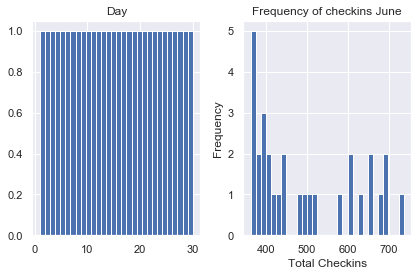

In [48]:
jun.hist(bins=30)
plt.title('Frequency of checkins June')
plt.ylabel('Frequency')
plt.xlabel('Total Checkins')
plt.tight_layout()

In [49]:
jul = jul_checkins_2019.groupby('Day').count()
jul = jul.reset_index()
jul = jul.drop(drop, axis=1)
cjul = jul['name'].mean()

In [50]:
aug = aug_checkins_2019.groupby('Day').count()
aug = aug.reset_index()
aug = aug.drop(drop, axis=1)
caug = aug['name'].mean()

In [51]:
sep = sep_checkins_2019.groupby('Day').count()
sep = sep.reset_index()
sep = sep.drop(drop, axis=1)
csep = sep['name'].mean()

In [52]:
_oct = oct_checkins_2019.groupby('Day').count()
_oct = _oct.reset_index()
_oct = _oct.drop(drop, axis=1)
coct = _oct['name'].mean()

In [53]:
nov = nov_checkins_2019.groupby('Day').count()
nov = nov.reset_index()
nov = nov.drop(drop, axis=1)
cnov = nov['name'].mean()

In [54]:
dec = dec_checkins_2019.groupby('Day').count()
dec = dec.reset_index()
dec = dec.drop(drop, axis=1)
cdec = dec['name'].mean()

In [55]:
# Monthly weather data imports
jan2 = pd.read_csv('/Users/Lisa/capstone_1/data/jan.csv')
feb2 = pd.read_csv('/Users/Lisa/capstone_1/data/feb.csv')
mar2 = pd.read_csv('/Users/Lisa/capstone_1/data/mar.csv')
apr2 = pd.read_csv('/Users/Lisa/capstone_1/data/apr.csv')
may2 = pd.read_csv('/Users/Lisa/capstone_1/data/may.csv')
jun2 = pd.read_csv('/Users/Lisa/capstone_1/data/jun.csv')
jul2 = pd.read_csv('/Users/Lisa/capstone_1/data/jul.csv')
aug2 = pd.read_csv('/Users/Lisa/capstone_1/data/aug.csv')
sep2 = pd.read_csv('/Users/Lisa/capstone_1/data/sep.csv')
_oct2 = pd.read_csv('/Users/Lisa/capstone_1/data/oct.csv')
nov2 = pd.read_csv('/Users/Lisa/capstone_1/data/nov.csv')
dec2 = pd.read_csv('/Users/Lisa/capstone_1/data/dec.csv')

In [56]:
# Merge dataframes

In [57]:
# jan = jan.merge(jan2, how='left', on='Day')
# jan.drop(drop, axis=1)

### <center> Monthly Weather Data <center>

In [58]:
jan_with_data = jan.merge(jan2, how='left', on='Day')
jan_with_data = jan_with_data.drop("Unnamed: 0", axis=1)
wjan = jan_with_data['Indicator'].mean()
jan_with_data
pos_jan = jan_with_data[jan_with_data['Indicator'] > 0]
neg_jan = jan_with_data[jan_with_data['Indicator'] == 0]
pos_jan
neg_jan

,Day,name,Condition,Indicator
0,1.0,467,mostly cloudy,0
4,5.0,723,cloudy,0
5,6.0,637,cloudy,0
6,7.0,395,partly cloudy,0
8,9.0,448,cloudy,0
9,10.0,447,cloudy,0
11,12.0,715,mostly cloudy,0
12,13.0,677,mostly cloudy,0
13,14.0,397,cloudy,0
14,15.0,416,cloudy,0


In [59]:
feb_with_data = feb.merge(feb2, how='left', on='Day')
feb_with_data = feb_with_data.drop("Unnamed: 0", axis=1)
wfeb = feb_with_data['Indicator'].mean()
pos_feb = feb_with_data[feb_with_data['Indicator'] > 0]
neg_feb = feb_with_data[feb_with_data['Indicator'] == 0]


In [60]:
mar_with_data = mar.merge(mar2, how='left', on='Day')
mar_with_data = mar_with_data.drop("Unnamed: 0", axis=1)
wmar = mar_with_data['Indicator'].mean()
pos_mar = mar_with_data[mar_with_data['Indicator'] > 0]
neg_mar = mar_with_data[mar_with_data['Indicator'] == 0]

In [61]:
apr_with_data = apr.merge(apr2, how='left', on='Day')
apr_with_data = apr_with_data.drop("Unnamed: 0", axis=1)
wapr = apr_with_data['Indicator'].mean()
pos_apr = apr_with_data[apr_with_data['Indicator'] > 0]
neg_apr = apr_with_data[apr_with_data['Indicator'] == 0]

In [62]:
may_with_data = may.merge(may2, how='left', on='Day')
may_with_data = may_with_data.drop("Unnamed: 0", axis=1)
wmay = may_with_data['Indicator'].mean()
pos_may = may_with_data[may_with_data['Indicator'] > 0]
neg_may = may_with_data[may_with_data['Indicator'] == 0]
# may_with_data

In [63]:
jun_with_data = jun.merge(jun2, how='left', on='Day')
jun_with_data = jun_with_data.drop("Unnamed: 0", axis=1)
wjun = jun_with_data['Indicator'].mean()
pos_jun = jun_with_data[jun_with_data['Indicator'] > 0]
neg_jun = jun_with_data[jun_with_data['Indicator'] == 0]
# jun_with_data

In [64]:
jul_with_data = jul.merge(jul2, how='left', on='Day')
jul_with_data = jul_with_data.drop("Unnamed: 0", axis=1)
wjul = jul_with_data['Indicator'].mean()
pos_jul = jul_with_data[jul_with_data['Indicator'] > 0]
neg_jul = jul_with_data[jul_with_data['Indicator'] == 0]

In [65]:
aug_with_data = aug.merge(aug2, how='left', on='Day')
aug_with_data = aug_with_data.drop("Unnamed: 0", axis=1)
waug = aug_with_data['Indicator'].mean()
pos_aug = aug_with_data[aug_with_data['Indicator'] > 0]
neg_aug = aug_with_data[aug_with_data['Indicator'] == 0]

In [66]:
sep_with_data = sep.merge(sep2, how='left', on='Day')
sep_with_data = sep_with_data.drop("Unnamed: 0", axis=1)
wsep = sep_with_data['Indicator'].mean()
pos_sep = sep_with_data[sep_with_data['Indicator'] > 0]
neg_sep = sep_with_data[sep_with_data['Indicator'] == 0]

In [67]:
oct_with_data = _oct.merge(_oct2, how='left', on='Day')
oct_with_data = oct_with_data.drop("Unnamed: 0", axis=1)
woct = oct_with_data['Indicator'].mean()
pos_oct = oct_with_data[oct_with_data['Indicator'] > 0]
neg_oct = oct_with_data[oct_with_data['Indicator'] == 0]

In [68]:
nov_with_data = nov.merge(nov2, how='left', on='Day')
nov_with_data = nov_with_data.drop("Unnamed: 0", axis=1)
wnov = nov_with_data['Indicator'].mean()
pos_nov = nov_with_data[nov_with_data['Indicator'] > 0]
neg_nov = nov_with_data[nov_with_data['Indicator'] == 0]

In [69]:
dec_with_data = dec.merge(dec2, how='left', on='Day')
dec_with_data = dec_with_data.drop("Unnamed: 0", axis=1)
wdec = dec_with_data['Indicator'].mean()
pos_dec = dec_with_data[dec_with_data['Indicator'] > 0]
neg_dec = dec_with_data[dec_with_data['Indicator'] == 0]

In [70]:
mean_checkins_by_month = [cjan, cfeb, cmar, capr, cmay, cjun, cjul, caug, csep, coct, cnov, cdec]
mean_checkins_by_month

[516.0967741935484,
 539.7857142857143,
 571.1935483870968,
 530.0666666666667,
 522.4193548387096,
 495.96666666666664,
 457.19354838709677,
 488.06451612903226,
 468.4,
 454.03225806451616,
 452.0,
 403.61538461538464]

In [71]:
mean_weather_by_month = [wjan, wfeb, wmar, wapr, wmay, wjun, wjul, waug, wsep, woct, wnov, wdec]
mean_weather_by_month

[0.3225806451612903,
 0.39285714285714285,
 0.41935483870967744,
 0.4666666666666667,
 0.41935483870967744,
 0.6,
 0.41935483870967744,
 0.5161290322580645,
 0.4,
 0.9032258064516129,
 0.36666666666666664,
 0.23076923076923078]

In [ ]:
#TRY TO GET ALL POSITIVE WEATHER AND NEGATIVE WEATHERS INTO TWO ARRAYS

In [113]:
pos = [pos_feb, pos_mar, pos_apr, pos_may, pos_jun, pos_jul, pos_aug, pos_sep, pos_oct, pos_nov, pos_dec]

In [124]:
neg = [neg_feb, neg_mar, neg_apr, neg_may, neg_jun, neg_jul, neg_aug, neg_sep, neg_oct, neg_nov, neg_dec]

In [122]:
all_pos = pd.concat([pos_feb, pos_mar, pos_apr, pos_may, pos_jun, pos_jul, pos_aug, pos_sep, pos_oct, pos_nov, pos_dec], ignore_index=True, axis=0)

In [123]:
all_pos

,Day,name,Condition,Indicator
0,1.0,493,mostly sunny,1
1,6.0,423,mostly sunny,1
2,7.0,437,mostly sunny,1
3,8.0,477,mostly sunny,1
4,11.0,417,mostly sunny,1
...,...,...,...,...
147,22.0,461,mostly sunny,1
148,26.0,351,mostly sunny,1
149,10.0,334,mostly sunny,1
150,11.0,350,mostly sunny,1


In [125]:
all_neg = pd.concat([neg_feb, neg_mar, neg_apr, neg_may, neg_jun, neg_jul, neg_aug, neg_sep, neg_oct, neg_nov, neg_dec], ignore_index=True, axis=0)

In [126]:
all_neg

,Day,name,Condition,Indicator
0,2.0,742,cloudy,0
1,3.0,644,cloudy,0
2,4.0,323,mostly cloudy,0
3,5.0,401,mostly cloudy,0
4,9.0,812,cloudy,0
...,...,...,...,...
159,6.0,422,cloudy,0
160,7.0,655,cloudy,0
161,8.0,582,cloudy,0
162,9.0,355,mostly cloudy,0


In [72]:
# stats.ttest_1samp(jan_with_data)

### <center> Statistical Testing <center>

In [73]:
# Example from Lecture
'''
binomial = stats.binom(n=70, p=1/7)

fig, ax = plt.subplots(1, figsize=(10, 4))
ax.bar(range(70), [binomial.pmf(i) for i in range(70)], color="grey")
ax.set_xlabel("Number of posts on a Sunday")
ax.set_ylabel("Probability")
ax.set_title("Distribution under null hypothesis")
    ax.axvline(x=binomial.ppf(.95)+.5)
bars = ax.bar(range(16,30), [binomial.pmf(i) for i in range(16,30)], color="red")
ax.legend(("fail reject H0", "reject H0"))
'''

'\nbinomial = stats.binom(n=70, p=1/7)\n\nfig, ax = plt.subplots(1, figsize=(10, 4))\nax.bar(range(70), [binomial.pmf(i) for i in range(70)], color="grey")\nax.set_xlabel("Number of posts on a Sunday")\nax.set_ylabel("Probability")\nax.set_title("Distribution under null hypothesis")\n    ax.axvline(x=binomial.ppf(.95)+.5)\nbars = ax.bar(range(16,30), [binomial.pmf(i) for i in range(16,30)], color="red")\nax.legend(("fail reject H0", "reject H0"))\n'

In [74]:
# Lecture P-value
'''
prob_equal_or_more_extreme = 1 - binomial.cdf(day_dict["Sunday"]-1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(
prob_equal_or_more_extreme)
)
'''

'\nprob_equal_or_more_extreme = 1 - binomial.cdf(day_dict["Sunday"]-1)\nprint("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(\nprob_equal_or_more_extreme)\n)\n'

In [75]:
# Establish Critical Value
a = .05